In [ ]:
# WE WILL BE TRAINING ON 40 CLASSES OUT OF 55 CLASSES (1-40)
# THE REMAINING 15 CLASSES WILL BE LATER USED IN THE EVALUATION PHASE (41-55)

# IMPORTING LIBRARIES

In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

import tensorflow as tf
from tensorflow.keras import initializers
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.regularizers import l2
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# PREPARING THE DATASET

In [ ]:
if not os.path.exists('/content/train'):
  os.makedirs('/content/train')

os.chdir('/content/drive/My Drive/UNSW-Intern')
!unrar x '/content/drive/My Drive/UNSW-Intern/CEDAR-signatures.rar'  '/content/train'

os.chdir('/content/train/signatures/full_org')
!rm /content/train/signatures/full_org/Thumbs.db

In [4]:
# DEFINING THE PARAMETERS
total_classes = 55
num_classes = 40
img_per_class = 24
batch_size = 32
img_height = 128
img_width = 128

In [5]:
# LOADING TRAINING IMAGES

def get_images(path, train=True):
  ids = os.listdir(path + '/full_org')
  if train:
    X = np.zeros((num_classes, img_per_class, img_height, img_width,1), dtype = np.float32)
    y = np.zeros((img_per_class*num_classes,1))

  else:
    X = np.zeros((total_classes-num_classes, img_per_class, img_height, img_width, 1), dtype = np.float32)
    y = np.zeros((img_per_class*(total_classes-num_classes),1))

  if train:
    print('Getting and resizing training images ... ')
    for i in tqdm_notebook(range(num_classes)):
      for j in range(img_per_class):
        #Load Images
        img = load_img(path + '/full_org/' + 'original_' + str(i+1) + '_' + str(j+1) + '.png', grayscale=True)
        x_img = img_to_array(img)
        #print("YOOOOOO ",x_img.shape)
        x_img = resize(x_img, (img_height, img_width), mode = 'constant', preserve_range=True)
        #print("YOOOOOO ",x_img.shape)
        #Load Images
        y1 = np.array([i+1])
        # Save Images       
        X[i,j,...] = x_img/255
        #print("YOOOOOO ",X.shape)
        y[i*img_per_class + j] = y1

    else:
      print('Getting and resizing validation images ... ')
      for i in tqdm_notebook(range(total_classes-num_classes)):
        for j in range(img_per_class):
          #Load Images
          img = load_img(path + '/full_org/' + 'original_' + str(i+1+num_classes) + '_' + str(j+1) + '.png', grayscale=True)
          x_img = img_to_array(img)
          #print("YOOOOOO ",x_img.shape)
          x_img = resize(x_img, (img_height, img_width), mode = 'constant', preserve_range=True)
          #print("YOOOOOO ",x_img.shape)
          #Load Images
          y1 = np.array([i+1+num_classes])
          # Save Images       
          X[i,j,...] = x_img/255
          #print("YOOOOOO ",X.shape)
          y[i*img_per_class + j] = y1       

  X = np.squeeze(X,axis=-1)
  print('Done!')
  return X,y

X_train,y_train = get_images('/content/train/signatures', True)
X_valid,y_valid = get_images('/content/train/signatures', False)

Getting and resizing training images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Getting and resizing validation images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Done!
Done!


# PREPARING PAIRS OF IMAGES FOR ONE SHOT LEARNING

In [6]:
def get_batch(X_train, batch_size, s='train'):

  # Creating a batch of n pairs, half same class, half different class

  if s == 'train':
    X = X_train

  n_classes, n_examples, h, w = X_train.shape

  # Randomly sampling several classes to use in the batch
  rng = np.random.default_rng()
  categories = rng.choice(num_classes, size = (batch_size,), replace = False)

  # Initialising two empty arrays for the input image batch
  pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)] 

  # Initialising target vector
  target = np.zeros((batch_size,))

  # make one half of it '1s' and the other as '0s'
  target[batch_size//2:] = 1
  for i in range(batch_size):
    category_1 = categories[i]
    idx_1 = np.random.randint(0,n_examples)
    pairs[0][i,:,:,:] = X[category_1,idx_1].reshape(h,w,1)

    # Pick images of same class for 1st half, different for 2nd
    idx_2 = np.random.randint(0,n_examples)
    if i >= batch_size//2:
      category_2 = category_1
    else:
      # add a random number to the category modulo n classes to ensure 2nd image has a different category
      category_2 = (category_1 + np.random.randint(1,n_classes)) % (n_classes)

    pairs[1][i,:,:,:] = X[category_2, idx_2].reshape(h,w,1)


  return pairs, target


#pairs,target = get_batch(X, batch_size,"train")

In [7]:
# GENERATOR FUNCTION FOR THE GET_BATCH FUNCTION TO INPUT IN FIT.GENERATOR CALL

def generate(Xtrain, batch_size, s = "train"):
  while True:
    pairs,target = get_batch(Xtrain,batch_size, s)
    yield pairs,target


In [8]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)    

# DEFINING THE MODEL ARCHITECTURE

In [32]:
# DEFINING THE MODEL ARCHITECTURE 

def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initializers.RandomNormal(stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.RandomNormal(mean=0.5,stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.RandomNormal(mean=0.5,stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.RandomNormal(mean=0.5,stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.RandomNormal(mean=0.5,stddev=0.01)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initializers.RandomNormal(mean=0.5,stddev=0.01))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

# VALIDATION AND TESTING FUNCTIONS

In [39]:
  def make_oneshot_task(N,s="val"):

        if s == "val":
          X = X_valid
        else:
          X = X_train  

        # Creating pairs of test image, support set for testing N way one shot learning
        n_classes, n_examples, h, w = X.shape
        indices = np.random.randint(0,n_examples,size=(N,))

        categories = rng.choice(range(n_classes),size=(N,),replace=False)
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
  
  def test_oneshot(model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... ".format(k,N))
        for i in range(k):
            inputs, targets = make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy ".format(percent_correct,N))
        return percent_correct



In [34]:
model = get_siamese_model((128,128,1))
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         68307776    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_3[0][0]    

# COMPILING AND TRAINING THE MODEL 

In [35]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [ ]:
# TRAINING THE MODEL

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 10 # interval for printing loss (iterations)
batch_size = 20
n_iter = 5000
N_way = 10 # how many classes for testing one-shot tasks>
n_val = 25 # how many one-shot tasks to validate on?
best = -1
weights_path = 'Siamese.h5'
weights_path2 = '/content/drive/My Drive/UNSW-Intern/weights/Siamese.h5'
if os.path.exists(weights_path2):
  model.load_weights(weights_path2)


val_accs = []
losses = []
print("Starting training process!")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batch(X_train,batch_size,"train")
    loss=model.train_on_batch(inputs,targets)
    print("-------------")
    print("Loss after iteration {0}: {1} \n".format(i,loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(model,N_way,n_val,verbose=True)
        val_accs.append(val_acc)  # Storing validation accuracies after every 10 iterations
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best),"therefore","saving the weights to: {0}".format(weights_path))
            model.save_weights(weights_path2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))
        losses.append(loss)  # Storing losses after every 10 iterations



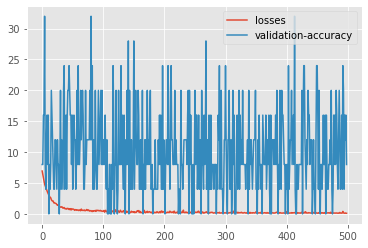

In [37]:
plt.plot(losses,label = 'losses')
plt.plot(val_accs,label = 'validation-accuracy')
plt.legend()

# TESTING THE MODEL WITH N-WAY LEARNING METRICS

Evaluating model on 450 random 1 way one-shot learning tasks ... 
Got an average of 100.0% 1 way one-shot learning accuracy 
Evaluating model on 450 random 1 way one-shot learning tasks ... 
Got an average of 100.0% 1 way one-shot learning accuracy 
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 
Got an average of 29.555555555555557% 3 way one-shot learning accuracy 
Evaluating model on 450 random 3 way one-shot learning tasks ... 
Got an average of 99.55555555555556% 3 way one-shot learning accuracy 
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 
Got an average of 16.22222222222222% 5 way one-shot learning accuracy 
Evaluating model on 450 random 5 way one-shot learning tasks ... 
Got an average of 99.55555555555556% 5 way one-shot learning accuracy 
Evaluating nearest neighbour on 450 unique 5 wa

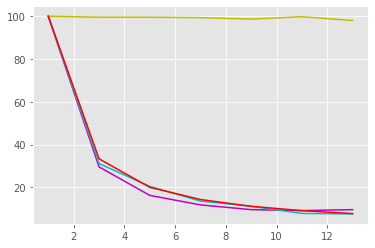

In [41]:
 # TESTING THE MODEL 
 
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 15, 2)
resume =  False
validation_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    validation_accs.append(test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials))
    
#plot the accuracy vs num categories for each
plt.plot(ways, validation_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()